Data scaled.
Parameters initialized.
mu:
[[0.46625131 0.0139487 ]
 [0.18753547 0.15211905]]
cov:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
alpha:
[0.5 0.5]
times: 0
times: 1
times: 2
times: 3
times: 4
times: 5
times: 6
times: 7
times: 8
times: 9
times: 10
times: 11
times: 12
times: 13
times: 14
times: 15
times: 16
times: 17
times: 18
times: 19
times: 20
times: 21
times: 22
times: 23
times: 24
times: 25
times: 26
times: 27
times: 28
times: 29
times: 30
times: 31
times: 32
times: 33
times: 34
times: 35


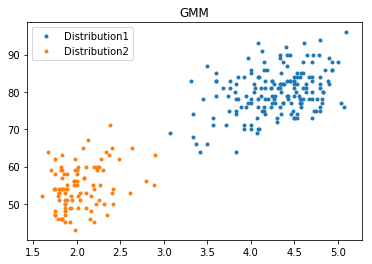

In [2]:
# -*- coding: utf-8 -*-
# ----------------------------------------------------
# Copyright (c) 2017, Wray Zheng. All Rights Reserved.
# Distributed under the BSD License.
# ----------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# DEBUG = True

######################################################
# 调试输出函数
# 由全局变量 DEBUG 控制输出
######################################################
def debug(*args, **kwargs):
    global DEBUG
    if DEBUG:
        print(*args, **kwargs)


######################################################
# 第 k 个模型的高斯分布密度函数
# 每 i 行表示第 i 个样本在各模型中的出现概率
# 返回一维列表
######################################################
def phi(Y, mu_k, cov_k):
    norm = multivariate_normal(mean=mu_k, cov=cov_k)
    return norm.pdf(Y)


######################################################
# E 步：计算每个模型对样本的响应度
# Y 为样本矩阵，每个样本一行，只有一个特征时为列向量
# mu 为均值多维数组，每行表示一个样本各个特征的均值
# cov 为协方差矩阵的数组，alpha 为模型响应度数组
######################################################
def getExpectation(Y, mu, cov, alpha):
    # 样本数
    N = Y.shape[0]
    # 模型数
    K = alpha.shape[0]

    # 为避免使用单个高斯模型或样本，导致返回结果的类型不一致
    # 因此要求样本数和模型个数必须大于1
    assert N > 1, "There must be more than one sample!"
    assert K > 1, "There must be more than one gaussian model!"

    # 响应度矩阵，行对应样本，列对应响应度
    gamma = np.zeros((N, K))

    # 计算各模型中所有样本出现的概率，行对应样本，列对应模型
    prob = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = phi(Y, mu[k], cov[k])
    gamma = np.mat(gamma)

    # 计算每个模型对每个样本的响应度
    for k in range(K):
        gamma[:, k] = alpha[k] * gamma[:, k]
    for i in range(N):
        gamma[i, :] /= np.sum(gamma[i, :])
    return gamma


######################################################
# M 步：迭代模型参数
# Y 为样本矩阵，gamma 为响应度矩阵
######################################################
def maximize(Y, gamma):
    # 样本数和特征数
    N, D = Y.shape
    # 模型数
    K = gamma.shape[1]

    #初始化参数值
    mu = np.zeros((K, D))
    cov = []
    alpha = np.zeros(K)

    # 更新每个模型的参数
    for k in range(K):
        # 第 k 个模型对所有样本的响应度之和
        Nk = np.sum(gamma[:, k])
        # 更新 mu
        # 对每个特征求均值
        for d in range(D):
            mu[k, d] = np.sum(np.multiply(gamma[:, k], Y[:, d])) / Nk
        # 更新 cov
        cov_k = np.mat(np.zeros((D, D)))
        for i in range(N):
            cov_k += gamma[i, k] * (Y[i] - mu[k]).T * (Y[i] - mu[k]) / Nk
        cov.append(cov_k)
        # 更新 alpha
        alpha[k] = Nk / N
    cov = np.array(cov)
    return mu, cov, alpha


######################################################
# 数据预处理
# 将所有数据都缩放到 0 和 1 之间
######################################################
def scale_data(Y):
    # 对每一维特征分别进行缩放
    for i in range(Y.shape[1]):
        max_ = Y[:, i].max()
        min_ = Y[:, i].min()
        Y[:, i] = (Y[:, i] - min_) / (max_ - min_)
    debug("Data scaled.")
    return Y


######################################################
# 初始化模型参数
# shape 是表示样本规模的二元组，(样本数, 特征数)
# K 表示模型个数
######################################################
def init_params(shape, K):
    N, D = shape
    mu = np.random.rand(K, D)
    cov = np.array([np.eye(D)] * K)
    alpha = np.array([1.0 / K] * K)
    debug("Parameters initialized.")
    debug("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha


######################################################
# 高斯混合模型 EM 算法
# 给定样本矩阵 Y，计算模型参数
# K 为模型个数
# times 为迭代次数
######################################################
def GMM_EM(Y, K, times):
    Y = scale_data(Y)
    mu, cov, alpha = init_params(Y.shape, K)
    delta = 0.000001
    for i in range(times):
        print("times: {}".format(i))
        gamma = getExpectation(Y, mu, cov, alpha)
        last_mu = mu
        last_cov = cov
        last_alpha = alpha
        mu, cov, alpha = maximize(Y, gamma)
        mu_delta = np.sum(np.abs(last_mu - mu))
        cov_delta = np.sum(np.abs(last_cov - cov))
        alpha_delta = np.sum(np.abs(last_alpha - alpha))
        if mu_delta < delta and cov_delta < delta and alpha_delta <delta:
            break

    return mu, cov, alpha



# 设置调试模式
DEBUG = True

# 载入数据
import csv

csvFile = open(r"old faithful.csv")
reader = csv.reader(csvFile)


x_ = []
y_ = []
x = []
for item in reader:
    # 忽略第一行
    if reader.line_num == 1:
        continue
    x_.append(float(item[1]))
    y_.append(float(item[2]))

Y = np.concatenate((np.array(x_)[:,np.newaxis],np.array(y_)[:,np.newaxis]),axis = 1)

csvFile.close()
matY = np.matrix(Y, copy=True)

# 模型个数，即聚类的类别个数
K = 2

# 计算 GMM 模型参数
mu, cov, alpha = GMM_EM(matY, K, 100)

# 根据 GMM 模型，对样本数据进行聚类，一个模型对应一个类别
N = Y.shape[0]
# 求当前模型参数下，各模型对样本的响应度矩阵
gamma = getExpectation(matY, mu, cov, alpha)
# 对每个样本，求响应度最大的模型下标，作为其类别标识
category = gamma.argmax(axis=1).flatten().tolist()[0]
# 将每个样本放入对应类别的列表中
class1 = np.array([Y[i] for i in range(N) if category[i] == 0])
class2 = np.array([Y[i] for i in range(N) if category[i] == 1])

# 绘制聚类结果
plt.plot(class1[:, 0], class1[:, 1], '.', label="Distribution1")
plt.plot(class2[:, 0], class2[:, 1], '.', label="Distribution2")
plt.legend(loc="best")
plt.title("GMM")
plt.show()